## Model Selection:

### evaluate the performace of using only jaccard as loss function

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import glob
import os
from helper import *
%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras.preprocessing import image
from keras.losses import binary_crossentropy ## loss function
## tensorboard
from time import time
## model
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.utils import set_trainable

In [3]:
### GPU memory setup
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [4]:
### detect GPU
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

### parameters

In [4]:
# define backbone name
BACKBONE = 'resnet34'

dir_path = "../data/sample_data/"
outdir_path = "../result/miniBatch" + BACKBONE + "/"

seed = 1

# data augmentation parameters
data_gen_args = dict(#rescale=1./255,
                     rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range = 0.05,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

# model trainig
EPOCHS = 20
BATCH_SIZE = 8

### load data

In [5]:
## load data
x_train = load_image_from_folder(dir_path + "train_image")
y_train = load_image_from_folder(dir_path + "train_mask")
x_test =load_image_from_folder(dir_path + "validate_image")
y_test =load_image_from_folder(dir_path + "validate_mask")

### turn mask into non-RGB, binary
y_train = y_train.mean(axis=3)/255
y_test = y_test.mean(axis=3)/255

### reshape to tensor
y_train = y_train.reshape((-1, 224, 224,1))
y_test = y_test.reshape((-1, 224, 224,1))

In [7]:
### visualize image/mask overlay
#plt.imshow(mask_overlay(x_train[0], y_train[0]*255, img_format = "image"))

### data augmentation

In [6]:
### preprocessing based on BACKBONE
## for ResNet: RGB to BRG
preprocessing_fn = get_preprocessing(BACKBONE)
x_train = preprocessing_fn(x_train)
x_test = preprocessing_fn(x_test)

In [7]:
image_datagen = image.ImageDataGenerator(**data_gen_args)
mask_datagen = image.ImageDataGenerator(**data_gen_args)

### no standardization, no fit
#image_datagen.fit(x_train, augment=True, seed=seed)
#mask_datagen.fit(y_train, augment=True, seed=seed)


image_generator = image_datagen.flow(x_train, batch_size=BATCH_SIZE, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=BATCH_SIZE, seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

## train model

In [8]:
# prepare model
model = Unet(backbone_name=BACKBONE, encoder_weights='imagenet', freeze_encoder=True)
model.compile('Adam', loss = jaccardLoss, metrics = ['binary_accuracy', jaccard, dice])

# pretrain model decoder (freeze encode weights for 2 epochs)
model.fit_generator(train_generator, verbose = 0,
                    epochs=2,
                    steps_per_epoch = np.floor(len(x_train)/(BATCH_SIZE)))

# release all layers for training
set_trainable(model)

# train model
history = model.fit_generator(
                    train_generator,
                    validation_data=(x_test,y_test),
                    epochs = EPOCHS,
                    steps_per_epoch = np.floor(len(x_train)/(BATCH_SIZE)),
                    verbose = 1)

Epoch 1/20
7/7 [==============================] - 12s 2s/step - loss: 1.1247 - binary_accuracy: 0.5813 - jaccard: 0.3260 - dice: 0.4826 - val_loss: 1.5612 - val_binary_accuracy: 0.6945 - val_jaccard: 0.2124 - val_dice: 0.3453
Epoch 2/20
7/7 [==============================] - 1s 176ms/step - loss: 1.0583 - binary_accuracy: 0.6347 - jaccard: 0.3502 - dice: 0.5076 - val_loss: 1.5802 - val_binary_accuracy: 0.5579 - val_jaccard: 0.2063 - val_dice: 0.3402
Epoch 3/20
7/7 [==============================] - 1s 171ms/step - loss: 0.9552 - binary_accuracy: 0.6842 - jaccard: 0.3878 - dice: 0.5468 - val_loss: 1.4837 - val_binary_accuracy: 0.6294 - val_jaccard: 0.2269 - val_dice: 0.3675
Epoch 4/20
7/7 [==============================] - 1s 171ms/step - loss: 0.8913 - binary_accuracy: 0.7012 - jaccard: 0.4120 - dice: 0.5742 - val_loss: 1.3590 - val_binary_accuracy: 0.6734 - val_jaccard: 0.2574 - val_dice: 0.4082
Epoch 5/20
7/7 [==============================] - 1s 171ms/step - loss: 0.7248 - binary_ac

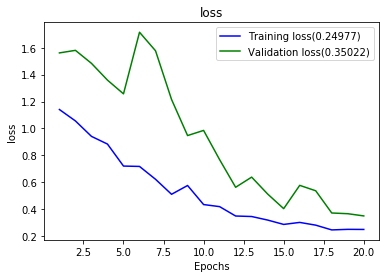

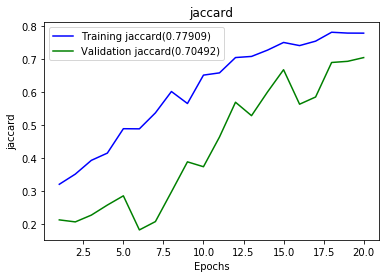

In [9]:
# plot training log
plot_history(history, key = 'loss')
plot_history(history, key = 'jaccard')

In [30]:
#model.save_weights(outdir_path + RESULT_NAME + ".h5")

## test on new image

In [15]:
test = load_image_from_folder(dir_path + "test_image")

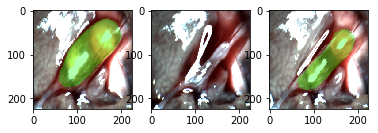

In [16]:
# model result
ypred = model.predict(preprocessing_fn(test))

## plot overlay
for i in range(len(test)):
    plt.subplot(1, len(test), i+1)
    plt.imshow(mask_overlay(test[i,:,:,:], (ypred[i] > 0.5).astype(int) * 255))
#plt.savefig(outdir_path + "test_merge.jpg")

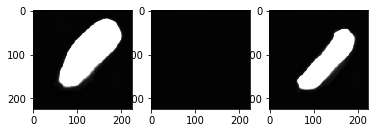

In [17]:
## plot mask
for i in range(len(test)):
    plt.subplot(1, len(test), i+1)
    plt.imshow(np.dstack((ypred[i], ypred[i], ypred[i])))
#plt.savefig(outdir_path + "test_mask.jpg")

### test on training data
- fisrt training data

In [10]:
# model result
ypred = model.predict(x_train[0].reshape(1,224,224,3))

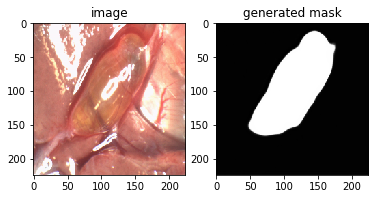

In [11]:
plt.subplot(121)
plt.title("image")
plt.imshow(preprocessing_fn(x_train[0]))

## ypred
plt.subplot(122)
plt.title("generated mask")
plt.imshow(np.dstack((ypred[0], ypred[0], ypred[0])))